# Q1. (10%): Ingest both of your train and test NSL-KDD dataset into one Postgres Database table

In [12]:
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.postgresql:postgresql:42.1.1 pyspark-shell'


spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)


print("APP Name :"+ spark.sparkContext.appName);
print("Master :"+ spark.sparkContext.master);

22/10/13 12:27:04 WARN Utils: Your hostname, Users-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.26 instead (on interface en0)
22/10/13 12:27:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/usr/local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/user/.ivy2/cache
The jars for the packages stored in: /Users/user/.ivy2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-23abf2be-42c5-4bad-891c-a9ca812473ac;1.0
	confs: [default]
	found org.postgresql#postgresql;42.1.1 in central
:: resolution report :: resolve 149ms :: artifacts dl 2ms
	:: modules in use:
	org.postgresql#postgresql;42.1.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-23abf2be-42c5-4bad-891c-a9ca812473ac
	confs: [de

22/10/13 12:27:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


APP Name :GenericAppName
Master :local[*]


/usr/local/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [13]:
from pyspark import SparkFiles

col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","classes","difficulty_level"]

db_properties={}
db_properties['username']="user"
db_properties['password']=""
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "NSLKDD"

def read_txt(data_file):    
    data_url = "https://www.andrew.cmu.edu/user/mfarag/14813/{}.txt".format(data_file)
    spark.sparkContext.addFile(data_url)
    df = spark.read.csv(SparkFiles.get("{}.txt".format(data_file)),header=False, inferSchema= True).toDF(*col_names)
    
    print(data_file, df.count())
    return df

train_df = read_txt('KDDTrain+')
test_df = read_txt('KDDTest+')

KDDTrain+ 125973


KDDTest+ 22544


In [14]:
db_properties={}
db_properties['username']="user"
db_properties['password']=""
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "NSLKDD"

train_df.write.format("jdbc")\
    .mode("overwrite")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .save()

test_df.write.format("jdbc")\
    .mode("append")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .save()

print('read OK!')

22/10/13 12:28:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


read OK!


In [15]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

if df_read.count() == (train_df.count() + test_df.count()):
    print('[SUCCESSFUL] Ingest both of your train and test NSL-KDD dataset into one Postgres Database table!')
    print('# of data (train & test dataset): {}'.format(df_read.count()))
else:
    print('[ERROR] ingest dataset failed !!!!')

[SUCCESSFUL] Ingest both of your train and test NSL-KDD dataset into one Postgres Database table!
# of data (train & test dataset): 148517


# Q2. (20%): What is the most popular attack on Twitter from the attacks listed in the dataset? Hint: You may use Kafka to fetch a 5-minute twitter feed. Your answer may vary depending on the time of the day you run your application. Run KafkaTweetListener in a separate notebook.

In [2]:
from kafka import KafkaConsumer
import json

topic_name = 'hw5'

kafka_consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='latest',
    enable_auto_commit=True,
    auto_commit_interval_ms =  5000,
    fetch_max_bytes = 128,
    max_poll_records = 100,
    value_deserializer=lambda x: x.decode('utf-8'))

In [9]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

from time import time

class_dict = {"neptune":0, "satan":0, "ipsweep":0}

i = 0

start = time()

for message in kafka_consumer:
    i = i + 1
    for class_name in class_dict.keys():
        if class_name in message.value:
            class_dict[class_name] += 1
            print(i, class_name, class_dict[class_name])
    
    if (time()-start) > 300:
        break
            
print('Done', i)

21 satan 1
25 satan 2
37 satan 3
45 satan 4
69 satan 5
72 neptune 1
99 satan 6
134 satan 7
149 satan 8
172 satan 9
203 satan 10
218 satan 11
224 satan 12
227 satan 13
Done 248


In [10]:
class_dict

{'neptune': 1, 'satan': 13, 'ipsweep': 0}

#### the most popular attack on twitter in this 5-minute twitter is satan

# Q3. (20%): Visualize the most frequent 5 attacks in the dataset (No social media analytics are involved here). Hint: use a histogram for your visualization.

In [30]:
import pandas as pd
top_5 = pd.DataFrame(df_read.toPandas()['classes'].value_counts()[:5])
top_5['attack'] = top_5.index

top_5

,classes,attack
normal,77054,normal
neptune,45871,neptune
satan,4368,satan
ipsweep,3740,ipsweep
smurf,3311,smurf


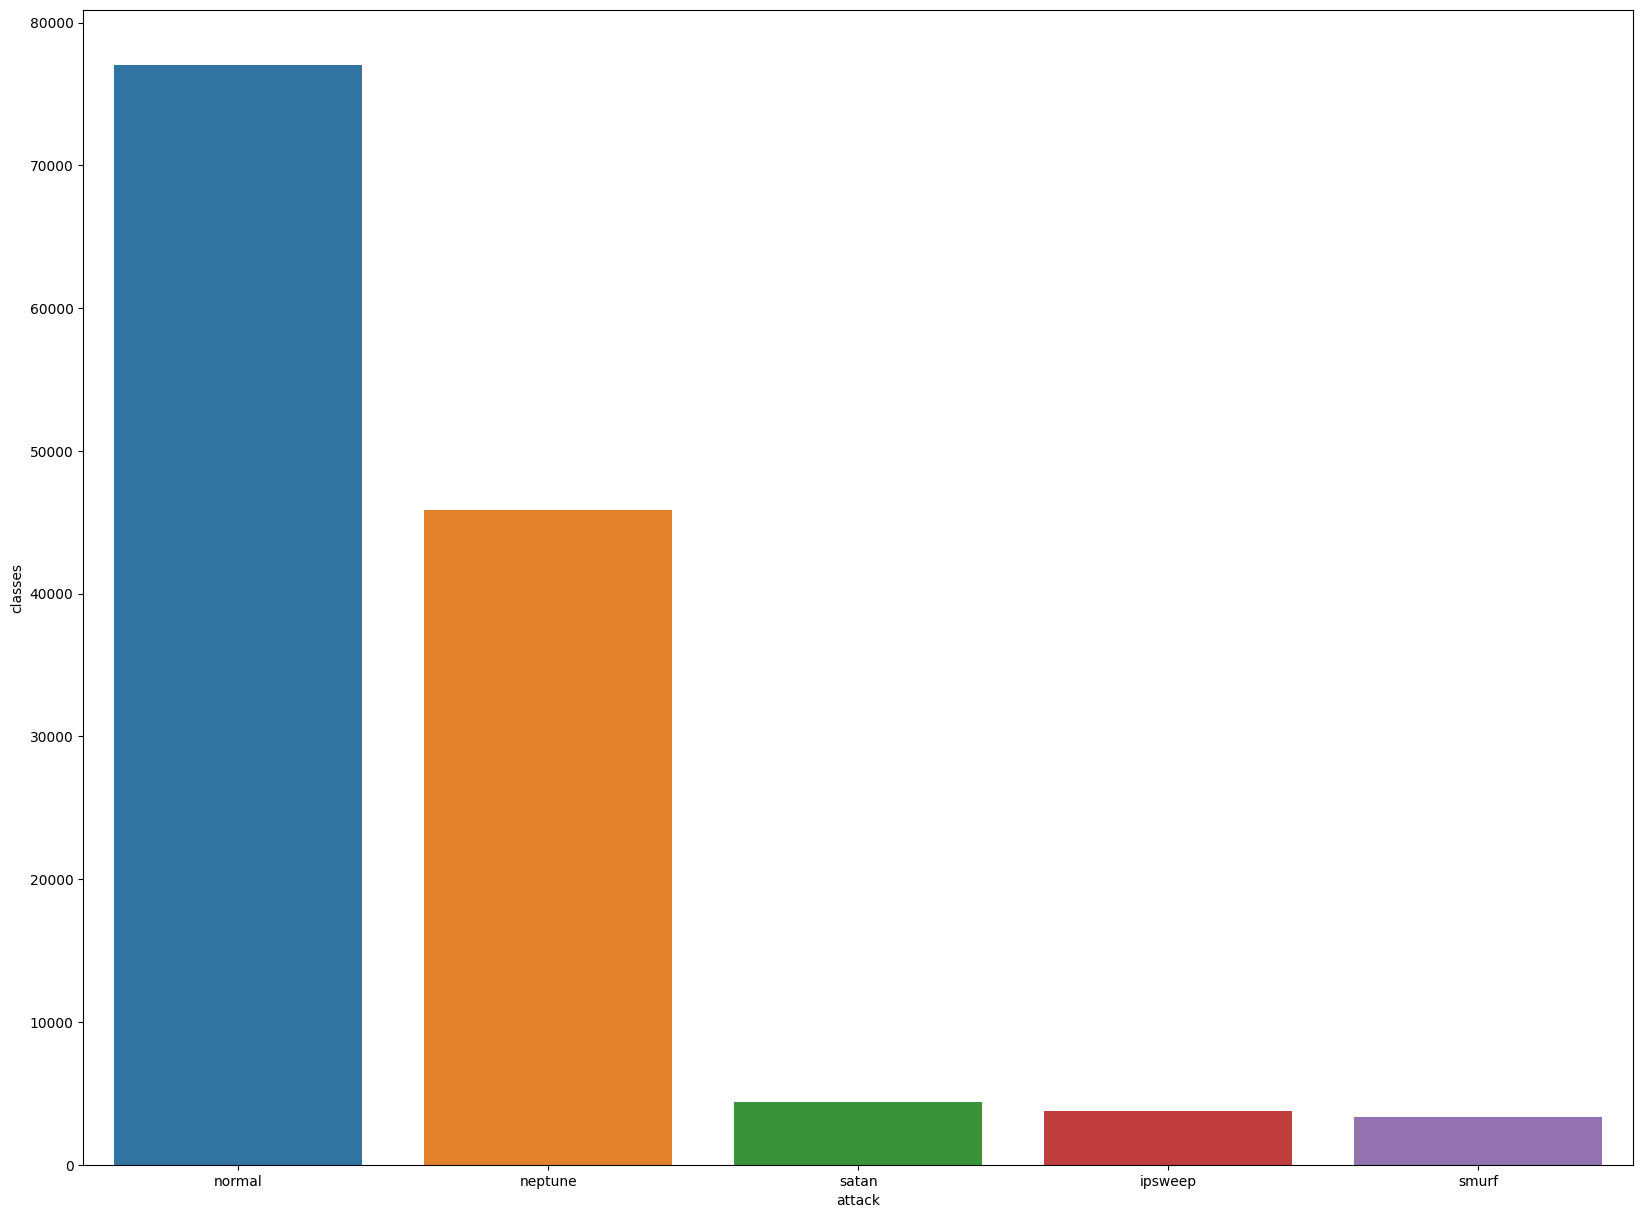

In [31]:
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt

plt.figure( figsize = ( 20, 15 ) )
sns.barplot( x="attack", y="classes", data=top_5)
plt.show()

# Q4. (50%): Use the Machine Learning Process Flow chart shown in the lecture to conduct all the feature engineering steps that are required to be done on the NFL-Pro- Bowl dataset. 
Limit your data cleaning and engineering to Plays.csv.
Stop at the data scaling stage of the process flow chart in Phase-2. (Make sure to conduct phase-1 as well).

### 1. Ingest Data from CSV and Insert them into PostgreSQL¶

In [41]:
df = spark.read.csv('plays.csv',header=True, inferSchema=True)

print(df.count())
df.printSchema()
df.show(1, vertical=True)

14193
root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel.offense: string (nullable = true)
 |-- defendersInTheBox: string (nullable = true)
 |-- numberOfPassRushers: string (nullable = true)
 |-- personnel.defense: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- KickReturnYard

In [42]:
db_properties={}
db_properties['username']="user"
db_properties['password']=""
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "plays"

df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

### 2. Data Cleaning


#### 2-1. renaming columns

In [63]:
tempList = []
for col in df.columns:
    new_name = col.strip()
    new_name = "".join(new_name.split())
    new_name = new_name.replace('.','_')
    tempList.append(new_name)
print(tempList)

df = df.toDF(*tempList)
df.printSchema()

['gameId', 'playId', 'quarter', 'GameClock', 'down', 'yardsToGo', 'possessionTeam', 'yardlineSide', 'yardlineNumber', 'offenseFormation', 'personnel_offense', 'defendersInTheBox', 'numberOfPassRushers', 'personnel_defense', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'HomeScoreAfterPlay', 'VisitorScoreAfterPlay', 'isPenalty', 'isSTPlay', 'SpecialTeamsPlayType', 'KickReturnYardage', 'PassLength', 'PassResult', 'YardsAfterCatch', 'PlayResult', 'playDescription']
root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- defendersInTheBox: string (nullable = true)
 |

Remove special symbols and spaces from column names

#### 2-2. dropping duplicate rows

In [65]:
unique_df = df.distinct()

print('before', df.count(), 'after', unique_df.count())

before 14193 after 14193


Tes result shows that no duplicate rows in the data

#### 2-3. casting column data types

In [66]:
cols = ["yardlineNumber", "defendersInTheBox", "numberOfPassRushers", "KickReturnYardage", "PassLength", "YardsAfterCatch"]

casted_types_df = unique_df
for col in cols:
    casted_types_df = casted_types_df.withColumn(col, casted_types_df[col].cast("integer"))

casted_types_df.printSchema()


root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: integer (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- defendersInTheBox: integer (nullable = true)
 |-- numberOfPassRushers: integer (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- KickReturnYardage

Cast 6 column types from string to intenger

#### 2-4. Handling Missing Values

In [148]:
from pyspark.sql.functions import *

cols = [c for c in casted_types_df.columns if c not in ["GameClock", "isPenalty", "isSTPlay"]]

null_counts_casted_types_df = casted_types_df.select([count(when(isnan(c) | col(c).isNull() | col(c).contains('NA'), c)).alias(c) \
                        for c in cols])

null_counts_casted_types_df.show(truncate=False, vertical=True)

-RECORD 0-----------------------
 gameId                 | 0     
 playId                 | 0     
 quarter                | 0     
 down                   | 0     
 yardsToGo              | 0     
 possessionTeam         | 0     
 yardlineSide           | 180   
 yardlineNumber         | 180   
 offenseFormation       | 2773  
 personnel_offense      | 2625  
 defendersInTheBox      | 2637  
 numberOfPassRushers    | 7483  
 personnel_defense      | 2625  
 HomeScoreBeforePlay    | 0     
 VisitorScoreBeforePlay | 0     
 HomeScoreAfterPlay     | 0     
 VisitorScoreAfterPlay  | 0     
 SpecialTeamsPlayType   | 11557 
 KickReturnYardage      | 13489 
 PassLength             | 7932  
 PassResult             | 7230  
 YardsAfterCatch        | 10256 
 PlayResult             | 0     
 playDescription        | 417   



In [149]:
compact_df = casted_types_df.drop("SpecialTeamsPlayType", "numberOfPassRushers", "KickReturnYardage", "PassLength", "PassResult",
                                  "YardsAfterCatch")

compact_df.printSchema()

print("before", len(casted_types_df.columns), "after", len(compact_df.columns))

root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: integer (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- defendersInTheBox: integer (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- PlayResult: integer (nullable = true)
 |-- playDescription: string (nullable = true)

before 27 after 21


Drop 4 columns with more than 50% of null values

In [150]:
compact_df.toPandas()['defendersInTheBox'].value_counts()

/usr/local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


6.0     4435
7.0     3554
8.0     1568
5.0     1291
4.0      391
9.0      194
10.0      50
11.0      38
3.0       33
2.0        2
Name: defendersInTheBox, dtype: int64

In [151]:
fillna_df = compact_df.fillna(6.0, subset=["defendersInTheBox"])

fillna_df.toPandas()['defendersInTheBox'].value_counts()

/usr/local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


6     7072
7     3554
8     1568
5     1291
4      391
9      194
10      50
11      38
3       33
2        2
Name: defendersInTheBox, dtype: int64

fill na in defendersInTheBox by the mode (because defendersInTheBox should be integer, can't fill by average)

In [206]:
from pyspark.sql.functions import col

fillna_df_with_na_dropped_rows = fillna_df.na.drop()

#fillna_df_with_na_dropped_rows = \
#    fillna_df_with_na_dropped_rows.filter((df.yardlineSide != 'NA') & (df.offenseFormation != 'NA') & \
#                                          (df.personnel_offense != 'NA') & (df.personnel_defense != 'NA'))

print('before', fillna_df.count(), 'after', fillna_df_with_na_dropped_rows.count())
print('drop rate', int((fillna_df.count()-fillna_df_with_na_dropped_rows.count())/fillna_df.count()*100), '%')

before 14193 after 14013
drop rate 1 %


drop all rows with null value(s) (which is hard to fill)

### 3. Feature Engineering

#### 3.1. Classify type of variables

In [207]:
fillna_df_with_na_dropped_rows.printSchema()

root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: integer (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel_offense: string (nullable = true)
 |-- defendersInTheBox: integer (nullable = true)
 |-- personnel_defense: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- PlayResult: integer (nullable = true)
 |-- playDescription: string (nullable = true)



[Continuous Variables]: yardsToGo, yardlineNumber, numberOfPassRushers, HomeScoreBeforePlay, VisitorScoreBeforePlay....

[Categorical Variables]:
* Binary Variables: isPenalty, isSTPlay...
* Ordinal Variables: quarter, down, defendersInTheBox, GameClock ... 
* Nominal Variables: offenseFormation, possessionTeam, yardlineSide, personnel_offense, personnel_offense, PassResult...

In [208]:
fillna_df_with_na_dropped_rows = fillna_df_with_na_dropped_rows.drop('gameId', 'playId','GameClock', 'playDescription')

fillna_df_with_na_dropped_rows.columns

['quarter',
 'down',
 'yardsToGo',
 'possessionTeam',
 'yardlineSide',
 'yardlineNumber',
 'offenseFormation',
 'personnel_offense',
 'defendersInTheBox',
 'personnel_defense',
 'HomeScoreBeforePlay',
 'VisitorScoreBeforePlay',
 'HomeScoreAfterPlay',
 'VisitorScoreAfterPlay',
 'isPenalty',
 'isSTPlay',
 'PlayResult']

#### 3.2  using IQR to spot Outliers

In [209]:
fillna_df_with_na_dropped_rows.summary().show(truncate=False, vertical=True)

-RECORD 0--------------------------------------------------
 summary                | count                            
 quarter                | 14013                            
 down                   | 14013                            
 yardsToGo              | 14013                            
 possessionTeam         | 14013                            
 yardlineSide           | 14013                            
 yardlineNumber         | 14013                            
 offenseFormation       | 14013                            
 personnel_offense      | 14013                            
 defendersInTheBox      | 14013                            
 personnel_defense      | 14013                            
 HomeScoreBeforePlay    | 14013                            
 VisitorScoreBeforePlay | 14013                            
 HomeScoreAfterPlay     | 14013                            
 VisitorScoreAfterPlay  | 14013                            
 PlayResult             | 14013         

In [210]:
numeric_features = [feature[0] for feature in fillna_df_with_na_dropped_rows.dtypes if feature[1] in ('int','double')]
numeric_features = [f for f in numeric_features if f not in ["gameId", "playId", "quarter", 'down']]

numeric_features

['yardsToGo',
 'yardlineNumber',
 'defendersInTheBox',
 'HomeScoreBeforePlay',
 'VisitorScoreBeforePlay',
 'HomeScoreAfterPlay',
 'VisitorScoreAfterPlay',
 'PlayResult']

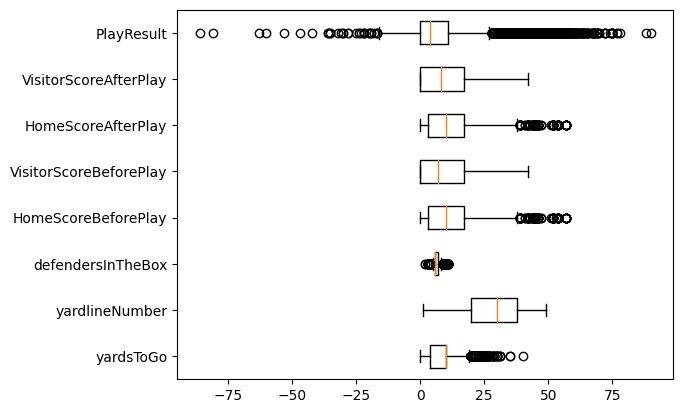

In [211]:
import matplotlib.pyplot as plt

converted_data = fillna_df_with_na_dropped_rows[numeric_features].toPandas()

figure = plt.boxplot(converted_data, labels=numeric_features, vert=False)

In [212]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1] in ('int','double')]
    numeric_columns = [f for f in numeric_columns if f not in ["gameId", "playId", "quarter", 'down']]

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

df_with_outlier_handling = find_outliers(fillna_df_with_na_dropped_rows)

df_with_outlier_handling.show(1, vertical=True)


-RECORD 0----------------------------------
 quarter                | 2                
 down                   | 1                
 yardsToGo              | 10               
 possessionTeam         | DET              
 yardlineSide           | ARI              
 yardlineNumber         | 19               
 offenseFormation       | SHOTGUN          
 personnel_offense      | 1 RB, 1 TE, 3 WR 
 defendersInTheBox      | 6                
 personnel_defense      | 2 DL, 4 LB, 5 DB 
 HomeScoreBeforePlay    | 0                
 VisitorScoreBeforePlay | 10               
 HomeScoreAfterPlay     | 0                
 VisitorScoreAfterPlay  | 10               
 isPenalty              | false            
 isSTPlay               | false            
 PlayResult             | 6                
 total_outliers         | 0                
only showing top 1 row



In [213]:
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             1| 2731|
|             3|   41|
|             4|    4|
|             2|  282|
|             0|10955|
+--------------+-----+



In [214]:
df_with_substituted_na_and_outliers = df_with_outlier_handling.filter(col('total_Outliers')<=1)

df_with_substituted_na_and_outliers.toPandas().count()
print('before', df_with_outlier_handling.count())
print('after', df_with_substituted_na_and_outliers.count())

before 14013
after 13686


drop all rows with outlier(s) more than 1 (only 2.33% which is acceptable)

#### 3-3. drop highly correlated features

In [215]:
correlation_matrix = df_with_substituted_na_and_outliers.toPandas().corr()
print(correlation_matrix)

                         quarter      down  yardsToGo  yardlineNumber  \
quarter                 1.000000  0.011077   0.006713       -0.007285   
down                    0.011077  1.000000   0.105337        0.004951   
yardsToGo               0.006713  0.105337   1.000000        0.062179   
yardlineNumber         -0.007285  0.004951   0.062179        1.000000   
defendersInTheBox      -0.032588 -0.148782  -0.077004       -0.124922   
HomeScoreBeforePlay     0.633048 -0.040857  -0.040363       -0.000377   
VisitorScoreBeforePlay  0.691844 -0.034621  -0.030570        0.003497   
HomeScoreAfterPlay      0.630357 -0.035776  -0.047815       -0.017437   
VisitorScoreAfterPlay   0.690784 -0.028283  -0.036857       -0.012171   
isPenalty               0.003524  0.095832  -0.000609       -0.001801   
isSTPlay               -0.018978  0.044047  -0.408440       -0.010347   
PlayResult             -0.025973  0.027253  -0.210102        0.161731   
total_outliers          0.026098  0.047078  -0.1208

/var/folders/rs/d4b8bh7j2x52l_21_42s43sm0000gn/T/ipykernel_84753/1692095180.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_with_substituted_na_and_outliers.toPandas().corr()


In [216]:
df_with_handled_correlations = df_with_substituted_na_and_outliers\
                .drop("HomeScoreBeforePlay","VisitorScoreBeforePlay")

df_with_handled_correlations.columns

['quarter',
 'down',
 'yardsToGo',
 'possessionTeam',
 'yardlineSide',
 'yardlineNumber',
 'offenseFormation',
 'personnel_offense',
 'defendersInTheBox',
 'personnel_defense',
 'HomeScoreAfterPlay',
 'VisitorScoreAfterPlay',
 'isPenalty',
 'isSTPlay',
 'PlayResult',
 'total_outliers']

#### 3-4. Handle Binary Variables (by casting them)

In [217]:
df_with_handled_binary = (df_with_handled_correlations
              .withColumn("isPenalty_encoded", \
                          df_with_handled_correlations["isPenalty"].cast("integer")))

df_with_handled_binary = (df_with_handled_binary
              .withColumn("isSTPlay_encoded", \
                          df_with_handled_binary["isSTPlay"].cast("integer")))

df_with_handled_binary.select("isPenalty","isPenalty_encoded").distinct().show()
df_with_handled_binary.select("isSTPlay", "isSTPlay_encoded").distinct().show()

+---------+-----------------+
|isPenalty|isPenalty_encoded|
+---------+-----------------+
|     true|                1|
|    false|                0|
+---------+-----------------+

+--------+----------------+
|isSTPlay|isSTPlay_encoded|
+--------+----------------+
|    true|               1|
|   false|               0|
+--------+----------------+



In [218]:
df_with_handled_binary = df_with_handled_binary.drop("isPenalty", "isSTPlay")

df_with_handled_binary.columns

['quarter',
 'down',
 'yardsToGo',
 'possessionTeam',
 'yardlineSide',
 'yardlineNumber',
 'offenseFormation',
 'personnel_offense',
 'defendersInTheBox',
 'personnel_defense',
 'HomeScoreAfterPlay',
 'VisitorScoreAfterPlay',
 'PlayResult',
 'total_outliers',
 'isPenalty_encoded',
 'isSTPlay_encoded']

#### 3-5. Handling Ordinal and Nominal Variables

Nominal Variables:offenseFormation, possessionTeam, yardlineSide, personnel_offense, personnel_defense, PassResult

In [228]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


# first part : transform the columns to numeric
stage_1 = StringIndexer(inputCol= 'offenseFormation', outputCol= 'offenseFormation_index')
stage_2 = StringIndexer(inputCol= 'possessionTeam', outputCol= 'possessionTeam_index')
stage_3 = StringIndexer(inputCol= 'yardlineSide', outputCol= 'yardlineSide_index')
stage_4 = StringIndexer(inputCol= 'personnel_offense', outputCol= 'personnel_offense_index')
stage_5 = StringIndexer(inputCol= 'personnel_defense', outputCol= 'personnel_defense_index')


# second part : one-hot encode the numeric columns
stage_6= OneHotEncoder(inputCols=["offenseFormation_index","possessionTeam_index",
                                  "yardlineSide_index", "personnel_offense_index", "personnel_defense_index"], 
                        outputCols=['offenseFormation_encoded','possessionTeam_encoded',
                                   'yardlineSide_encoded', 'personnel_offense_encoded',
                                   'personnel_defense_encoded'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5, stage_6])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(df_with_handled_binary)
df_encoded = pipeline_model.transform(df_with_handled_binary)

print(df_encoded.select("offenseFormation").distinct().count())

df_encoded.select("offenseFormation","offenseFormation_index","offenseFormation_encoded")\
                .distinct().toPandas()


9


,offenseFormation,offenseFormation_index,offenseFormation_encoded
0,PISTOL,5.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
1,SINGLEBACK,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,SHOTGUN,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,WILDCAT,7.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
4,JUMBO,6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)"
5,EMPTY,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)"
6,I_FORM,3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)"
7,NA,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
8,ACE,8.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


In [230]:
df_encoded = df_encoded.drop("offenseFormation","offenseFormation_index", \
                "possessionTeam","possessionTeam_index", \
                "yardlineSide","yardlineSide_index", "personnel_offense", "personnel_defense", \
                "personnel_offense_index", "personnel_defense_index")

df_encoded.printSchema()

root
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- yardlineNumber: integer (nullable = true)
 |-- defendersInTheBox: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- PlayResult: integer (nullable = true)
 |-- total_outliers: integer (nullable = false)
 |-- isPenalty_encoded: integer (nullable = true)
 |-- isSTPlay_encoded: integer (nullable = true)
 |-- offenseFormation_encoded: vector (nullable = true)
 |-- possessionTeam_encoded: vector (nullable = true)
 |-- yardlineSide_encoded: vector (nullable = true)
 |-- personnel_offense_encoded: vector (nullable = true)
 |-- personnel_defense_encoded: vector (nullable = true)



#### 3-6. Combining Features into Single Vector

In [231]:
feature_list = df_encoded.columns
print(feature_list)

['quarter', 'down', 'yardsToGo', 'yardlineNumber', 'defendersInTheBox', 'HomeScoreAfterPlay', 'VisitorScoreAfterPlay', 'PlayResult', 'total_outliers', 'isPenalty_encoded', 'isSTPlay_encoded', 'offenseFormation_encoded', 'possessionTeam_encoded', 'yardlineSide_encoded', 'personnel_offense_encoded', 'personnel_defense_encoded']


In [233]:
from pyspark.ml.feature import VectorAssembler


vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_encoded)
df_with_assembled_features.select("vectorized_features").show(1, truncate=False)

+------------------------------------------------------------------------------------------+
|vectorized_features                                                                       |
+------------------------------------------------------------------------------------------+
|(179,[0,1,2,3,4,6,7,11,37,52,81,131],[2.0,1.0,10.0,19.0,6.0,10.0,6.0,1.0,1.0,1.0,1.0,1.0])|
+------------------------------------------------------------------------------------------+
only showing top 1 row



In [234]:
df_with_assembled_features.select("vectorized_features","defendersInTheBox")\
    .distinct().toPandas()

,vectorized_features,defendersInTheBox
0,"(3.0, 2.0, 17.0, 13.0, 6.0, 10.0, 17.0, 0.0, 0...",6
1,"(3.0, 1.0, 10.0, 15.0, 8.0, 37.0, 0.0, 9.0, 0....",8
2,"(4.0, 3.0, 2.0, 40.0, 7.0, 28.0, 14.0, 0.0, 0....",7
3,"(3.0, 1.0, 10.0, 34.0, 6.0, 24.0, 16.0, 5.0, 0...",6
4,"(4.0, 2.0, 20.0, 30.0, 6.0, 21.0, 21.0, 16.0, ...",6
...,...,...
13638,"(4.0, 4.0, 11.0, 22.0, 6.0, 10.0, 23.0, 0.0, 0...",6
13639,"(3.0, 1.0, 10.0, 29.0, 7.0, 10.0, 13.0, 3.0, 0...",7
13640,"(3.0, 4.0, 4.0, 20.0, 6.0, 10.0, 13.0, 0.0, 0....",6
13641,"(4.0, 1.0, 10.0, 22.0, 6.0, 17.0, 24.0, 9.0, 0...",6


#### 3-7. Data Scaling

In [236]:
from pyspark.ml.feature import StandardScaler
standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select("defendersInTheBox","features").distinct().toPandas()

,defendersInTheBox,features
0,6,"(2.667564540773185, 0.8860746743406464, 2.1856..."
1,7,"(0.8891881802577283, 0.8860746743406464, 2.185..."
2,7,"(2.667564540773185, 1.7721493486812927, 0.2185..."
3,7,"(3.556752721030913, 0.8860746743406464, 2.1856..."
4,6,"(3.556752721030913, 1.7721493486812927, 2.1856..."
...,...,...
13638,5,"(1.7783763605154566, 2.658224023021939, 4.5898..."
13639,6,"(1.7783763605154566, 0.0, 0.0, 2.8292302442510..."
13640,6,"(1.7783763605154566, 2.658224023021939, 1.9670..."
13641,8,"(0.8891881802577283, 1.7721493486812927, 1.529..."
